### Libraries

In [1]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ggplot2)
library(ggpubr)
library(stringr)
library(reshape2)
library(ggh4x)
library(ggpattern)
library(ggtext)
library(fantaxtic)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



In [2]:
# create directories
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure3'), showWarnings = FALSE)

### Load data

In [3]:
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')
# normalize counts
ps_normalized <- transform_sample_counts(ps, function(x){x / sum(x)})
# find ids of follow-up subjects
sample_table <- sample_data(ps_normalized)
onlydewormed_ids <- sample_table[sample_table[['collection_timepoint']] == 'follow-up',]$host_subject_id
# select samples only from subjects who also participated in a follow-up study
ps_normalized <- subset_samples(ps_normalized, host_subject_id %in% onlydewormed_ids)
length(onlydewormed_ids)*2 == nsamples(ps_normalized)
ps_normalized

[1] TRUE

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 134 samples ]
sample_data() Sample Data:       [ 134 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

### Plot barplot agglomerated per baseline/follow-up including STH status

In [4]:
# create a 'time_and_STHStatus' metadata column
# this column has 4 values:
#    baseline_noSTH: a sample is from a baseline cohort, no STH eggs detected at the baseline
#    baseline_STH: a sample is from a baseline cohort, STH eggs detected at the baseline
#    followup_noSTH_noSTH: a sample is from a follow-up cohort, STH-negative at both: the baseline and the follow-up
#    followup_noSTH_STH: a sample is from a follow-up cohort, STH-negative at the baseline, STH-positive at the follow-up
#    followup_STH_noSTH: a sample is from a follow-up cohort, STH-positive at the baseline, STH-negative at the follow-up
#    followup_STH_STH: a sample is from a follow-up cohort, STH-positive at both: the baseline and the follow-up
# p.s. a sample is considered STH-negative at the given collection timepoint, 
# if no STH eggs were detected at the given timpoint
# p.p.s. a sample is considered STH-positive at the given collection timepoint, 
# if at least on STH egg  detected at the given timpoint

# create a new variable (the length = number of of samples) and name everyone as baseline_noSTH
time_and_STHStatus <- rep('baseline_noSTH', dim(sample_data(ps_normalized))[1])
# mark indexes (TRUE/FALSE) of baseline samples with detected STH at the baseline
time_and_STHStatus_baseline_all <- ((sample_data(ps_normalized)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps_normalized)[['sample_eggcountAnySTHs']] > 0))
# rename
time_and_STHStatus[time_and_STHStatus_baseline_all] <- 'baseline_STH'

# find IDs of participants who were STH-free at the baseline
host_subject_id <- sample_data(ps_normalized)[time_and_STHStatus == 'baseline_noSTH', ]$host_subject_id
noSTH<- (sample_data(ps_normalized)$host_subject_id %in% host_subject_id)&(sample_data(ps_normalized)$collection_timepoint == 'follow-up')

# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-free at the baseline
time_and_STHStatus_followup <- (sample_data(ps_normalized)[['collection_timepoint']] == 'follow-up') & noSTH
# name all of them followup_noSTH_noSTH
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_noSTH_noSTH'
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who  STH-free at the baseline and
# 3) there are STH eggs detected at the follow-up time point
time_and_STHStatus_followup <- ((sample_data(ps_normalized)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps_normalized)[['sample_eggcountAnySTHs']] > 0) & noSTH)
# rename all of them followup_noSTH_STH
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_noSTH_STH'

# find IDs of participants who were STH-positive at the baseline
host_subject_id <- sample_data(ps_normalized)[time_and_STHStatus == 'baseline_STH', ]$host_subject_id
STH <- (sample_data(ps_normalized)$host_subject_id %in% host_subject_id)&(sample_data(ps_normalized)$collection_timepoint == 'follow-up')
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who was STH-positive at the baseline
time_and_STHStatus_followup <- (sample_data(ps_normalized)[['collection_timepoint']] == 'follow-up') & STH
# rename such samples
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_STH_noSTH'
# mark indexes as TRUE if 
# 1) a sample is from a follow-up cohort and 
# 2) a sample belongs to the participant who was STH-positive at the baseline and
# 3) there are STH eggs detected at the follow-up time point
time_and_STHStatus_followup <- ((sample_data(ps_normalized)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps_normalized)[['sample_eggcountAnySTHs']] > 0) & STH)
# rename such samples
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_STH_STH'

In [5]:
# rename groups to combine follow-up sample with different STH status based on their baseline STH status
time_and_STHStatus <- factor(time_and_STHStatus) # factorize
levels(time_and_STHStatus) <- c('baseline_noSTH', 'baseline_STH', 
                               'followup_noSTH', 'followup_noSTH', 
                               'followup_STH', 'followup_STH') # regroup

In [6]:
# create a new column in phyloseq metadata table
sample_data(ps_normalized)['time_and_STHStatus'] <- as.character(time_and_STHStatus)

In [7]:
# compute the mean relative abundance per group defined by 'time_and_STHStatus' column
ps_merged_STH <- merge_samples(ps_normalized, group = "time_and_STHStatus", fun = sum)
ps_merged_STH <- transform_sample_counts(ps_merged_STH, function(x){x / sum(x)})

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


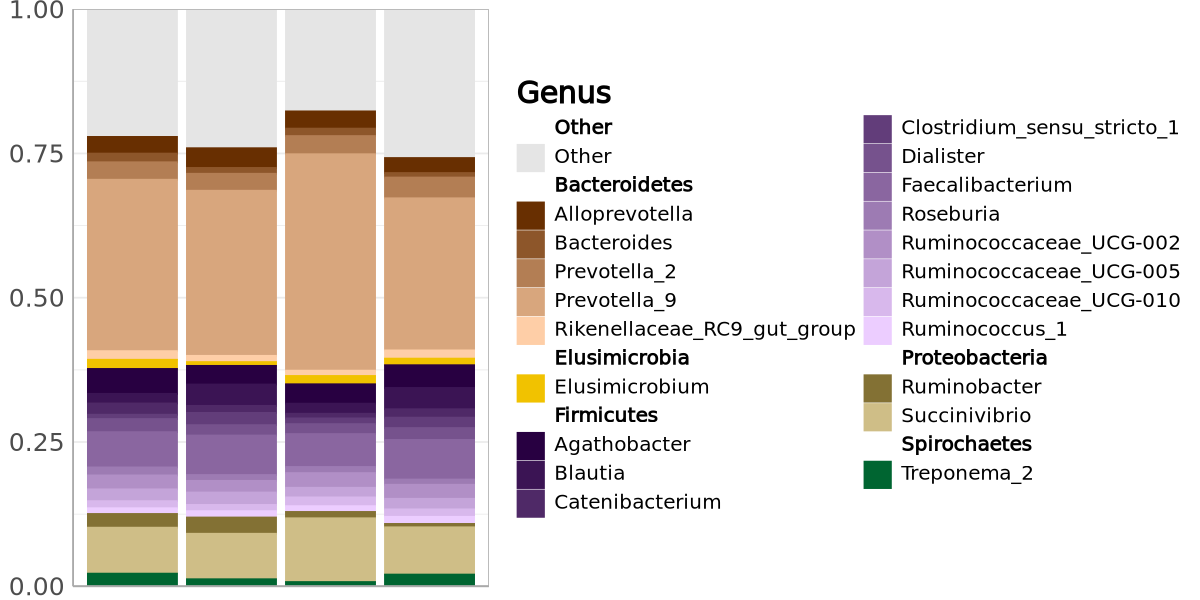

In [8]:
# Get the most abundant family and the most abundant genus within those phyla
width = 10
height = 5
options(repr.plot.width = width, repr.plot.height = height)

top_nested <- top_taxa(ps_merged_STH, 
                       n_taxa=20)

# Plot the relative abundances at two levels.
p <- plot_nested_bar(ps_obj = top_nested$ps_obj,
                top_level = "Phylum",
                nested_level = "Genus", 
                palette = c(Bacteroidetes = "#763501", 
                            Proteobacteria = "#b9a04f", 
                            Elusimicrobia = '#f1c200', 
                            Spirochaetes =  '#006531' 
                           )) +
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_blank(),
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 25, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_blank(), 
            text = element_text(size = 15), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            legend.text = element_markdown(),
            legend.title = element_text(size = 18, face="bold"),
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="right") 
p$data[['Sample']] <- factor(p$data[['Sample']], 
                                     levels=unlist(c('baseline_noSTH',
                                                       'followup_noSTH', 
                                                       'baseline_STH', 
                                                       'followup_STH')))
k = 0.3
ggsave(file=file.path('../../results/figures', 'figure3', 'stacked_plot.STH_baseline.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
p